<a href="https://colab.research.google.com/github/mihir70/Mask_Vs_No_Mask/blob/main/mobilev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import PIL
import cv2
from random import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

Importing the images with the help of glob

In [9]:
from glob import glob
non=list(glob('/content/drive/MyDrive/Mask_vs_No_Mask/data/anotherdataset/nomask/*.png'))
non=non[:2000]
len(non)

2000

In [10]:
mask=list(glob('/content/drive/MyDrive/Mask_vs_No_Mask/data/anotherdataset/mask/*.png'))
mask=mask[:2000]

Resizing images to 128,128

In [11]:
non_im=[]
for i in non:
  img=cv2.imread(i)
  img=cv2.resize(img,(128,128))
  non_im.append(img)



plotting some images

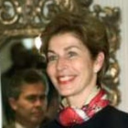

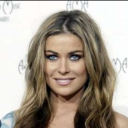

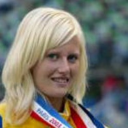

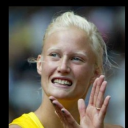

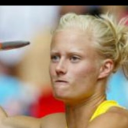

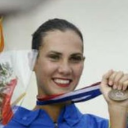

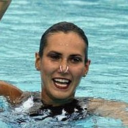

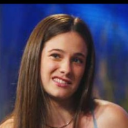

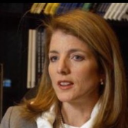

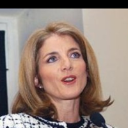

In [13]:
for i in range(10):
  cv2_imshow(non_im[i])

In [14]:
len(non_im)

2000

In [15]:
mask_im=[]
for i in mask:
  img=cv2.imread(i)
  img=cv2.resize(img,(128,128))
  mask_im.append(img)


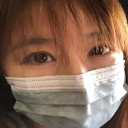

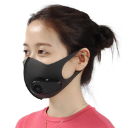

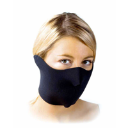

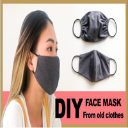

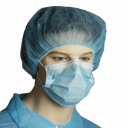

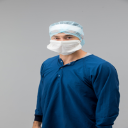

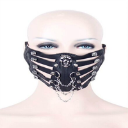

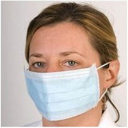

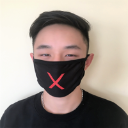

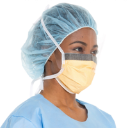

In [17]:
for i in range(10):
  cv2_imshow(mask_im[-i])

No. of Images in both classes

In [18]:
len(mask_im)
len(non_im)

2000

Converting rgb values of images from (0,255) to (0,1)

In [19]:
img_rows=128
img_cols=128
non_im=np.array(non_im)/255.0
mask_im=np.array(mask_im)/255.0

non_im = np.reshape(non_im, (non_im.shape[0], img_rows, img_cols, 3))
mask_im = np.reshape(mask_im, (mask_im.shape[0], img_rows, img_cols, 3))

In [20]:
type(non_im)
print(non_im.shape)
print(non_im[1])

(2000, 128, 128, 3)
[[[0.45098039 0.45490196 0.45098039]
  [0.45490196 0.45490196 0.45098039]
  [0.45098039 0.45098039 0.44705882]
  ...
  [0.45490196 0.45882353 0.45098039]
  [0.45490196 0.45882353 0.45098039]
  [0.45490196 0.45882353 0.44705882]]

 [[0.98039216 0.98431373 0.97647059]
  [0.98823529 0.99215686 0.98431373]
  [0.98431373 0.98823529 0.98431373]
  ...
  [0.99607843 1.         0.99215686]
  [0.99607843 1.         0.99215686]
  [0.99607843 1.         0.98823529]]

 [[0.98039216 0.98431373 0.97647059]
  [0.97647059 0.98431373 0.97254902]
  [0.98039216 0.98431373 0.97647059]
  ...
  [0.99215686 0.99607843 0.98823529]
  [0.99215686 0.99607843 0.99215686]
  [0.99215686 0.99607843 0.98431373]]

 ...

 [[0.36078431 0.28235294 0.15686275]
  [0.67058824 0.60784314 0.47843137]
  [0.83529412 0.78823529 0.66666667]
  ...
  [0.58039216 0.68235294 0.77647059]
  [0.55686275 0.65490196 0.74901961]
  [0.54901961 0.64313725 0.7372549 ]]

 [[0.4627451  0.38823529 0.25490196]
  [0.78823529 0.7

Concatenating Images of both classes

In [21]:
data=np.concatenate((non_im,mask_im),axis=0)
no=np.empty(2000)
no.fill(0) #0 for no mask
ye=np.empty(2000)
ye.fill(1)
label=np.concatenate((no,ye))

In [22]:
lb = LabelBinarizer()
label = lb.fit_transform(label)
label = to_categorical(label,num_classes=2)
label = np.array(label)

In [35]:
(X_train, X_test, y_train, y_test) = train_test_split(
    data, label, test_size=0.2, random_state=0)


In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [25]:
base = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input((128, 128, 3)),input_shape=(128,128,3))


9420800/9406464 [==============================] - 0s 0us/step


Making Layers as non trainable

In [26]:
for layer in base.layers:
    layer.trainable=False

Adding some layers at the end of the NN

In [27]:
model = base.output
model = MaxPooling2D()(model)
model = Flatten(name="flatten")(model)
model = Dense(128, activation="relu")(model)
model = Dropout(0.3)(model)
model = Dense(64, activation="relu")(model)
model = Dropout(0.2)(model)
model = Dense(2, activation="softmax")(model)


In [28]:
final = Model(inputs=base.input, outputs=model)
final.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [42]:
history=final.fit(X_train, y_train, epochs=50,validation_data=(X_test,y_test))


Epoch 1/50
100/100 [==============================] - 2s 23ms/step - loss: 3.4874e-04 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 0.9975
Epoch 2/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0012 - accuracy: 0.9994 - val_loss: 0.0106 - val_accuracy: 0.9962
Epoch 3/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0038 - accuracy: 0.9994 - val_loss: 0.0247 - val_accuracy: 0.9900
Epoch 4/50
100/100 [==============================] - 2s 23ms/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 0.0399 - val_accuracy: 0.9950
Epoch 5/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0013 - accuracy: 0.9994 - val_loss: 0.0254 - val_accuracy: 0.9962
Epoch 6/50
100/100 [==============================] - 2s 22ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0367 - val_accuracy: 0.9937
Epoch 7/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0262 - val_accuracy: 0.

Plotting accuracy curves

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


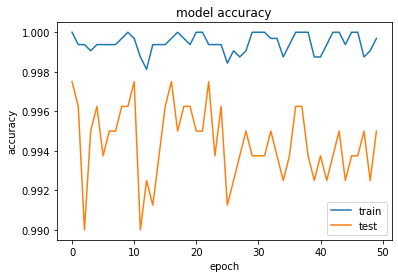

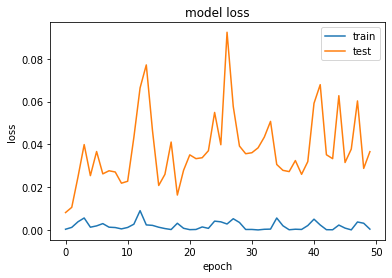

In [43]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [44]:

predictions = final.predict(X_test)


In [45]:
pred=lb.inverse_transform(predictions)
y_te=lb.inverse_transform(y_test)

In [46]:
from sklearn.metrics import accuracy_score
accuracy_score(y_te, pred)


0.995

Saving The Model For Future Use

In [ ]:
final.save('/content/drive/MyDrive/Mask_vs_No_Mask/MobileV2')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Mask_vs_No_Mask/MobileV2/assets
